## Intro 

In this notebook we will build, step by step, the background to use the Earth Mover Distance (EMD) to evaluate the the differences of distribution of genes with expression in their nearest neighbors. 

The notebook will be divided in several parts. First, we will explain the rationale for using the kNN, and how it is computed. For that we will use a randomized dataset, which contains the same number of reads (and zeros, if required) per cell, but whose reads have been distributed randomly. The random distribution of reads within the selected cells follows a binomial distribution. 

Second, we will infer which is the distribution in the kNN cells (we consider the kNN cells of cells which already have some expression). We will come to the conclusion that the convolution of the binomial distribution is indeed the best fitting distribution (convolution is explained later on in the notebook). 

Third, we will apply the fitting of distributions and their convolutions to real biological datasets. In fact, we do see that read distribution does not always follow a binomial distribution, and neither does the convolution. We will see which type of distribution fits best on the genes based on their average, percentage of zeros, and variance. Usually, genes with lower mean expression are best fitted with binomial distributions, but genes with greater mean expression require more general functions, like the johnsonsu (a generalization of the normal).

The main problem with this fitting is that we do not really know if the need of different distributions based on their mean, variance or percentage of zeros is somethign biologically relevant or not. However, we do indeed see that deviation of the kNN read distribution from the convolution of read distribution (which should reflect the distribution of reads in randomly chosen k neighbors) has a biological relevance; so we will be focusing on the divergence between the real kNN read distribution and the distribution from convolution.

To assess the difference between the two distributions we will use the Earth Mover Distance (EMD), also known as Wasserstein distance. There are many functions to evaluate difference between two distributions, like doing a Kolmogorov-Smirnov test, Kullback-Leiber distance, distribution absolute difference, Jensen-Shannon divergence, etc. The choice of EMD is, first, because of its simple and practical interpretation: EMD can be interpreted as the minimum *effort* to transform one distribution into the other. Second, it has been found that EMD performs best compared to other distribution comparison distances. Third, there are meny implementations of the EMD in python, which have significantly increased the time performance for EMD calculation.

* http://robotics.stanford.edu/~rubner/papers/rubnerIjcv00.pdf
* https://hal.archives-ouvertes.fr/hal-01984970/document

Instead of using EMD as such, we will apply a modification that will allow us to compare the distances with genes of different mean.

This third part of the analysis will be done in three different types of datasets: the first type consists of reads free in solution (that is, cell-free solution) which should constitute a negative control. There are two main datasets: one from Zheng (available at 10X) which contains reads of ERCCs, and the second dataset from Svensson et al consisting of reads from a cell line, obtained with different technologies. In these datasets we should observe that most genes' kNN read distributions are similar to the convolution of the read distribution, although oftentimes we will see they are not, and indeed we will clearly see that there are clusters of cells with greater gene expression. The second type of datasets are biological datasets consisting of cell lines. Those datasets should not have many highly variable genes, due to cell lines being supposedly "pure". The last type of datasets are *biological* datasets consisting of complex tissues with many cell types. 

In [1]:
# Imports here
import scanpy as sc
import numpy as np
import scipy.stats as sts
import scipy.optimize as opt
import pandas as pd
# import triku as tk
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib 
import matplotlib as mpl
from numba import jit, njit
import ray
from tqdm.notebook import tqdm
import scipy.signal as sgn
from pyemd import emd

import scanpy as sc

# Especial imports
from sklearn.decomposition import PCA
from umap.umap_ import fuzzy_simplicial_set, nearest_neighbors

# Parallel imports
import ray


random_state = 10

In [2]:
ray.logger.setLevel(logging.ERROR)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Selection of palettes for cluster coloring, and scatter values

magma = [plt.get_cmap('magma')(i) for i in np.linspace(0,1, 100)]
magma[0] = (0.88, 0.88, 0.88, 1)
magma = mpl.colors.LinearSegmentedColormap.from_list("", magma[:80])

# Discrete palette [Combination of BOLD and VIVID from carto colors]
bold_and_vivid = ['#7F3C8D','#11A579','#3969AC','#F2B701','#E73F74','#80BA5A','#E68310','#008695','#CF1C90',
           '#f97b72','#4b4b8f', '#E58606','#5D69B1','#52BCA3','#99C945','#CC61B0','#24796C','#DAA51B',
           '#2F8AC4','#764E9F','#ED645A','#CC3A8E']

prism = ['#5F4690', '#1D6996', '#38A6A5', '#0F8554', '#73AF48', '#EDAD08', '#E17C05', '#CC503E', '#94346E', '#6F4070', '#994E95']
prism = prism[::2] + prism[1::2]
safe = ['#88CCEE', '#CC6677', '#DDCC77', '#117733', '#332288', '#AA4499', '#44AA99', '#999933', '#882255', '#661100', '#6699CC']
vivid = ['#E58606', '#5D69B1', '#52BCA3', '#99C945', '#CC61B0', '#24796C', '#DAA51B', '#2F8AC4', '#764E9F', '#ED645A', '#CC3A8E']
bold = ['#7F3C8D', '#11A579', '#3969AC', '#F2B701', '#E73F74', '#80BA5A', '#E68310', '#008695', '#CF1C90', '#f97b72', '#4b4b8f']
# Diverging palettes
temps = ['#009392', '#39b185', '#9ccb86', '#e9e29c', '#eeb479', '#e88471', '#cf597e']

# Continuous palettes
teal = ['#d1eeea', '#a8dbd9', '#85c4c9', '#68abb8', '#4f90a6', '#3b738f', '#2a5674']

Here should go modules that must be installed, to be rememebered later on. These modules should not appear in the final notebook version.

In [5]:
pip install pyemd

Note: you may need to restart the kernel to use updated packages.


In [6]:
from bokeh.io import show, output_notebook, reset_output
from bokeh.plotting import figure
from bokeh.models import Circle, ColumnDataSource, Div, Grid, Line, LinearAxis, Plot, Range1d, Legend, LinearColorMapper, BasicTicker, PrintfTickFormatter, ColorBar
from bokeh.sampledata.unemployment1948 import data

reset_output()
output_notebook()

Loading BokehJS ...

# Functions
These part here will include all functions. They must be removed from the final version of the notebook, and should be integrated into the `.py` files

## Functions to retrieve count distribution in the kNN

In [7]:
def return_knn_indices(array, knn=None, return_random=False):
    if knn is None:
        knn = int(0.5 * array.shape[0] ** 0.5)
    pca = PCA(n_components=50, whiten=True, svd_solver='auto').fit_transform(array)
    
    if return_random:
        knn_indices = np.zeros((array.shape[0], knn))
        ran = np.arange(0, array.shape[0])
        for i in tqdm(ran):
            knn_indices[i, 1:] = np.random.choice(ran, knn-1, replace=False)
            
        knn_indices[:, 0] = np.arange(array.shape[0])            
        
    else:
        knn_indices, knn_dists, forest = nearest_neighbors(pca, n_neighbors=knn, metric='cosine',
                              random_state=np.random.RandomState(random_state), angular=False, metric_kwds={})
    
    
    return knn_indices.astype(int)

In [8]:
@njit
def get_counts_knn(arr_counts_per_cell, knn):
    counts = []
    for i in np.where(arr_counts_per_cell > 0)[0]:
        for trial in range(1):
            choices = np.concatenate((np.arange(0, i), np.arange(i+1, len(arr_counts_per_cell))))
            counts.append(np.sum(arr_counts_per_cell[np.random.choice(choices, knn-1, replace=False)]) +
                         arr_counts_per_cell[i])
       
    return np.array(counts)  

In [9]:
# @njit
def numbaaa(X_gene, NN_cells_with_positive_expression):
    return_list = []
    for cell in range(len(NN_cells_with_positive_expression)):
        return_list.append(X_gene[NN_cells_with_positive_expression[cell, :]].sum())
   
    return np.array(return_list)


@ray.remote
def return_expression_info_per_gene(gene_idx, adata_X, knn_indices, zero_counts, fill_zeros):
    # Select the expression column for that gene
    try:
        arr_expr_gene = np.asarray(adata_X[:, gene_idx].todense()).flatten()
    except:
        arr_expr_gene = np.asarray(adata_X[:, gene_idx]).flatten()
        
    # Select, from that column, the cells (rows) that have positive expression
    if zero_counts:
        selected_cells = np.arange(len(adata_X))
    else:
        selected_cells = np.argwhere(arr_expr_gene > 0).flatten()
   
    # Get the NN matrix for the cells with positive expression. This matrix is of n_cells x kNN
    NN_cells = knn_indices[selected_cells, :]
   
    # Apply a mask to select, from each cell, the neighbors that have positive expression
    # Here, we include the cell from which the kNN are extracted
    mask_neighbors_expressing = np.isin(NN_cells, selected_cells)[:, :]
   
    # Get the expression from the neighbors
    expression_in_neighbors = numbaaa(arr_expr_gene, NN_cells)
    
    if fill_zeros:
        expression_in_cells = np.zeros(adata_X.shape[0])
        expression_in_cells[selected_cells] = expression_in_neighbors
        return expression_in_cells
    else:
        return expression_in_neighbors


def return_expression_info(list_genes, adata, knn_indices, category_name = 0, zero_counts=False, 
                           fill_zeros=False):
    # This function returns a dictionary of genes: expression in kNN for gene, 
    # and also a dictionary of gene: category, where category is a number added by the user. This
    # will come in handy for plotting certain figures with different categories.
    dict_percentage_expressing_cells_kNN, dict_expression_per_kNN, dict_categories = {}, {}, {}
   

    list_idx_genes = [np.argwhere(adata.var_names == gene).flatten()[0] for gene in list_genes]
    
    ray.shutdown()
    ray.init()
    
    adata_X_obj = ray.put(adata.X)
    knn_indices_obj = ray.put(knn_indices)
    
    obj_ids_list = [return_expression_info_per_gene.remote(
       gene_idx=list_idx_genes[i],
       adata_X=adata_X_obj, 
       knn_indices=knn_indices_obj, 
       zero_counts=zero_counts, 
    fill_zeros=fill_zeros) for i in range(len(list_idx_genes))]
    
    obj_ids = ray.get(obj_ids_list)
    
    ray.shutdown()
    
    for i in range(len(obj_ids)):
        dict_expression_per_kNN[list_genes[i]] = obj_ids[i]
        dict_categories[list_genes[i]] = category_name
    
    
    return dict_expression_per_kNN, dict_categories

## Functions to randomize the count matrix

In [10]:
def return_per_zeros(mu, phi):
    # This formula is the expected proportion of zeros based on the mean (not log-transformed) and 
    # the variance. In realitym phi here should be 1/var, but it is easier to fit the inverse directly.
    return (phi/(mu + phi))**phi


def create_random_count_matrix(matrix=None, n_cells=1000, n_genes=1000, n_min_reads=None, n_max_reads=None,
                               method='binomial', phi=0.35):
    """
    The matrix should have Cells x Genes format.
    """

    if matrix is not None:
        n_reads_per_gene = matrix.sum(0).astype(int)
        n_zeros = (matrix == 0).sum(0)
        n_cells, n_genes = matrix.shape
    else:
        if n_max_reads is None: n_min_reads = int(n_cells * 0.2)
        if n_max_reads is None: n_max_reads = n_cells * 7
        n_reads_per_gene = np.linspace(n_min_reads, n_max_reads, n_genes, dtype=int)
#         percentage_zeros = return_per_zeros(n_reads_per_gene/n_cells, phi)
#         n_zeros = (percentage_zeros * n_cells).astype(int)

    matrix_random = np.zeros((n_cells, n_genes))

    for gene in tqdm(range(n_genes)):
        if method == 'binomial':
            rnd_idx = np.random.choice(np.arange(n_cells), n_reads_per_gene[gene])
            bincount = np.bincount(rnd_idx)
            matrix_random[:len(bincount), gene] = bincount

        else:
            raise TypeError('No method in list.')

        # elif method in ["negative binomial", 'nb']:
        #     if n_reads_per_gene[gene] + n_zeros > n_cells:
        #         idx_nonzero = np.random.choice(np.arange(n_cells), n_cells - n_zeros, replace=False)
        #         matrix_random[idx_nonzero, gene] += 1

    return matrix_random

## General matrix operations

In [11]:
def return_mean_per(matrix):
    # Returns the mean counts per gene, and the proportion of zeros
    n_reads_per_gene = matrix.sum(0).astype(int)
    n_zeros = (matrix == 0).sum(0)

    return n_reads_per_gene/matrix.shape[0], n_zeros/matrix.shape[0]

## Convolution functions
There should be, convolution of binomial (corrected only, uncorrected should be appearing on the notebook), johnsonsu, ..., and convolution from initial read distribution.

In [12]:
def apply_convolution_read_counts(d, knn = 5, threshold = 1, correct=True):
    arr_0 = d.pmf(np.arange(int(d.ppf(threshold)) + 5))
    if correct:
        arr_0[0] = 0
    
    arr_i = d.pmf(np.arange(int(d.ppf(threshold)) + 5))
    

    arr_con = sgn.fftconvolve(arr_0, arr_i,)
    
    arr_con  = arr_con[np.cumsum(arr_con) < threshold]
    arr_con[arr_con < 0] = 0
    
    # Theoretically we should do that, but the effects are really small because the number of cells are high
    for knni in range(2, knn):         
        arr_con = sgn.fftconvolve(arr_con, arr_i,)
        
        arr_con  = arr_con[np.cumsum(arr_con) < threshold]
        arr_con[arr_con < 0] = 0
        
    return sts.rv_discrete(a=0, b=len(arr_con), values=(range(len(arr_con)), arr_con/sum(arr_con))), arr_con

## EMD

In [13]:
def EMD(knn_counts, convolution, correct_std = True):
    dist_range = np.arange(max(knn_counts)+1)
    real_vals = np.bincount(knn_counts.astype(int))/len(knn_counts)
    conv_vals = convolution.pmf(np.arange(max(knn_counts)+1))
    
    d = sts.wasserstein_distance(dist_range, dist_range, real_vals, conv_vals)
    if correct_std: d /= convolution.std()
    return d

## Plotting functions

In [14]:
def plot_convolution(gene, adata, expression_counts_adata_norm_knn_norm, 
                     expression_counts_adata_norm_knn_random,
                     adata_random, expression_counts_adata_random_knn_norm, 
                     expression_counts_adata_random_knn_random):
    
    fig, axs = plt.subplots(2, 3, figsize=(12, 6))
    
    axs[0][0].set_title('Read counts, \n%s, adata'%gene)
    axs[0][1].set_title('Read random KNN counts, \n%s, knn = %s, adata'%(gene, knn))
    axs[0][2].set_title('Read KNN counts, \n%s, knn = %s, adata'%(gene, knn))

    counts_gene = adata[:, gene].X.ravel()
    knn_random_counts = expression_counts_adata_norm_knn_random[gene]
    knn_counts = expression_counts_adata_norm_knn_norm[gene]
    
    _ = axs[0][0].hist(counts_gene.tolist(), density=True, bins=int(max(counts_gene) - min(counts_gene)))
    _ = axs[0][1].hist(knn_random_counts, density=True, bins=int(max(knn_random_counts) - min(knn_random_counts)))
    _ = axs[0][2].hist(knn_counts, density=True, bins=int(max(knn_counts) - min(knn_counts)))

    x_counts, y_counts = np.unique(counts_gene, return_counts=True)
    d_c = sts.rv_discrete(a=0, b=len(counts_gene), values=(x_counts, y_counts/sum(y_counts)))

    convolution, _ = apply_convolution_read_counts(d_c, knn = knn, threshold = 1)

    range_ax = np.arange(int(1.2 * max(knn_counts)))

    axs[0][1].plot(range_ax + 0.5, convolution.pmf(range_ax))
    axs[0][2].plot(range_ax + 0.5, convolution.pmf(range_ax))
    
    d1 = EMD(knn_random_counts, convolution) 
    d2 = EMD(knn_counts, convolution) 

    axs[0][1].text(0.7 * axs[0][1].get_xlim()[1], 0.8 * axs[0][1].get_ylim()[1], '%.2f'%d1)
    axs[0][2].text(0.7 * axs[0][2].get_xlim()[1], 0.8 * axs[0][2].get_ylim()[1], '%.2f'%d2)

    
    
    axs[1][0].set_title('Read counts, \n%s, adata_random'%gene)
    axs[1][1].set_title('Read random KNN counts, \n%s, knn = %s, adata_random'%(gene, knn))
    axs[1][2].set_title('Read KNN counts, \n%s, knn = %s, adata_random'%(gene, knn))

    counts_gene = adata_random[:, gene].X.ravel()
    knn_random_counts = expression_counts_adata_random_knn_random[gene]
    knn_counts = expression_counts_adata_random_knn_norm[gene]
    
    _ = axs[1][0].hist(counts_gene.tolist(), density=True, bins=int(max(counts_gene) - min(counts_gene)))
    _ = axs[1][1].hist(knn_random_counts, density=True, bins=int(max(knn_random_counts) - min(knn_random_counts)))
    _ = axs[1][2].hist(knn_counts, density=True, bins=int(max(knn_counts) - min(knn_counts)))

    
    x_counts, y_counts = np.unique(counts_gene, return_counts=True)
    d_c = sts.rv_discrete(a=0, b=len(counts_gene), values=(x_counts, y_counts/sum(y_counts)))

    convolution, _ = apply_convolution_read_counts(d_c, knn = knn, threshold = 1)

    range_ax = np.arange(int(1.2 * max(knn_counts)))

    axs[1][1].plot(range_ax + 0.5, convolution.pmf(range_ax))
    axs[1][2].plot(range_ax + 0.5, convolution.pmf(range_ax))

    d1 = EMD(knn_random_counts, convolution) 
    d2 = EMD(knn_counts, convolution) 

    axs[1][1].text(0.7 * axs[1][1].get_xlim()[1], 0.8 * axs[1][1].get_ylim()[1], '%.2f'%d1)
    axs[1][2].text(0.7 * axs[1][2].get_xlim()[1], 0.8 * axs[1][2].get_ylim()[1], '%.2f'%d2)
    
    plt.tight_layout()

In [15]:
def compare_zeros_non_zeros(gene, adata, expression_counts_knn_norm, expression_counts_knn_norm_with_zeros):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    
    axs[0].set_title('Read kNN counts, \n%s, adata'%gene)
    axs[1].set_title('Read kNN counts, with zeros, \n%s, knn = %s, adata'%(gene, knn))

    counts_gene = adata[:, gene].X.ravel()
    knn_counts = expression_counts_knn_norm[gene]
    knn_counts_with_zeros = expression_counts_knn_norm_with_zeros[gene]
    
    _ = axs[0].hist(knn_counts, density=True, bins=int(max(knn_counts) - min(knn_counts)))
    _ = axs[1].hist(knn_counts_with_zeros, density=True, 
                       bins=int(max(knn_counts_with_zeros) - min(knn_counts_with_zeros)))

    x_counts, y_counts = np.unique(counts_gene, return_counts=True)
    d_c = sts.rv_discrete(a=0, b=len(counts_gene), values=(x_counts, y_counts/sum(y_counts)))

    convolution, _ = apply_convolution_read_counts(d_c, knn = knn, threshold = 1, correct=True)
    convolution_with_zeros, _ = apply_convolution_read_counts(d_c, knn = knn, threshold = 1, correct=False)

    range_ax = np.arange(int(0.95 * min(knn_counts)), int(1.05 * max(knn_counts)))
    range_ax_with_zeros = np.arange(int(0.95 * min(knn_counts_with_zeros)), 
                                    int(1.05 * max(knn_counts_with_zeros)))

    axs[0].plot(range_ax + 0.5, convolution.pmf(range_ax))
    axs[1].plot(range_ax_with_zeros + 0.5, convolution_with_zeros.pmf(range_ax_with_zeros))  
    
    d1 = EMD(knn_counts, convolution) 
    d0 = EMD(knn_counts_with_zeros, convolution_with_zeros) 
    
    axs[0].text(0.7 * axs[0].get_xlim()[1], 0.8 * axs[0].get_ylim()[1], '%.2f'%d1)
    axs[1].text(0.7 * axs[1].get_xlim()[1], 0.8 * axs[1].get_ylim()[1], '%.2f'%d0)

# Dataset manipulation
## Dataset download

In this section we will include the download and basic preprocessing of the datasets. In the first subsection we will download the datasets (already preprocessed, or to be preprocessed), and in the second section we will process them. The processing will consist will be the basic one from scanpy.

#### Svensson et al. (read solution - without cells)

* Human ERCC + brain on Chromium: https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-5480/

* Mouse ERCC + mESC on Smartseq2: https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-5481/

* Mouse ERCC + mESC on Smarter C1: https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-5483/

In [16]:
fastq_dir = "/media/seth/SETH_DATA/SETH_Alex/triku/data/svensson/"

In [17]:
# !cd $fastq_dir && aria2c -x 16 ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR187/006/ERR1876146/ERR1876146.fastq.gz --max-file-not-found 10 -c --file-allocation=none

#### 10x datasets
* neuron 10k: http://cf.10xgenomics.com/samples/cell-exp/3.0.0/neuron_10k_v3/neuron_10k_v3_filtered_feature_bc_matrix.h5

In [18]:
fastq_dir = "/media/seth/SETH_DATA/SETH_Alex/triku/data/10x/"

In [19]:
# !cd $fastq_dir && wget http://cf.10xgenomics.com/samples/cell-exp/3.0.0/neuron_10k_v3/neuron_10k_v3_filtered_feature_bc_matrix.h5

## Dataset Processing

#### Svensson et al. (read solution, without cells)

In [20]:
# For E-MTAB-5480
index_dir = "/media/seth/SETH_DATA/SETH_Alex/ARAUZO_02/seq_indexes/kallisto"
umis_dir = "/media/seth/SETH_DATA/SETH_Alex/Programs/"
fastq_dir = "/media/seth/SETH_DATA/SETH_Alex/triku/data/svensson/"

In [21]:
# you need to install umis from here
# !cd $umis_dir && git clone https://github.com/vals/umis && cd umis && pip install .

In [22]:
# transform fastq file to kallisto-readdable format
# THE FASTQ MUST BE UNZIPPED
# !cd $fastq_dir && python $fastq_dir/process_umi.py

In [23]:
# !loompy fromfq $fastq_dir/svensson10x.loom svensson10x $index_dir $fastq_dir/metadata.tab $fastq_dir/ERR1876146.fastq.gz $fastq_dir/ERR1876146_UMI.fastq.gz $fastq_dir/ERR1876146_CB.fastq.gz 

## Dataset Preprocessing
The preprocessing of the datasets consists of two parts:
- First, we will apply a basic processing (filter genes + PCA + neighbors + umap). We exclude HVGs and log / norm because log alters the structure of the dataset, and the structure of the % zeros VS mean graph.
- Second, we will apply a randomization of the matrix, i.e. for each gene, we will distribute its reads within the cells.  The distribution of those reads follows a binomial distribution, which we will see id the expected output. This random matrix will then be processed as the previous one.

#### Svensson et al. (read solution, without cells)

In [24]:
fastq_dir = "/media/seth/SETH_DATA/SETH_Alex/triku/data/svensson/"

In [25]:
svensson_10x_adata = sc.read_loom(fastq_dir + '/svensson10x.loom')
svensson_10x_adata.X = np.asarray(svensson_10x_adata.X.todense())
svensson_10x_adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [26]:
sc.pp.filter_genes(svensson_10x_adata, min_cells=20)
sc.pp.calculate_qc_metrics(svensson_10x_adata, inplace=True)
sc.pp.pca(svensson_10x_adata)
sc.pp.neighbors(svensson_10x_adata, metric='cosine')
sc.tl.umap(svensson_10x_adata)
sc.tl.leiden(svensson_10x_adata)

... storing 'Aliases' as categorical
... storing 'CcdsID' as categorical
... storing 'Chromosome' as categorical
... storing 'ChromosomeEnd' as categorical
... storing 'ChromosomeStart' as categorical
... storing 'CosmicID' as categorical
... storing 'DnaBindingDomain' as categorical
... storing 'FullName' as categorical
... storing 'GeneType' as categorical
... storing 'HgncID' as categorical
... storing 'IsTF' as categorical
... storing 'Location' as categorical
... storing 'LocationSortable' as categorical
... storing 'LocusGroup' as categorical
... storing 'LocusType' as categorical
... storing 'MgdID' as categorical
... storing 'MirBaseID' as categorical
... storing 'OmimID' as categorical
... storing 'PubmedID' as categorical
... storing 'RefseqID' as categorical
... storing 'RgdID' as categorical
... storing 'UcscID' as categorical
... storing 'UniprotID' as categorical
... storing 'VegaID' as categorical


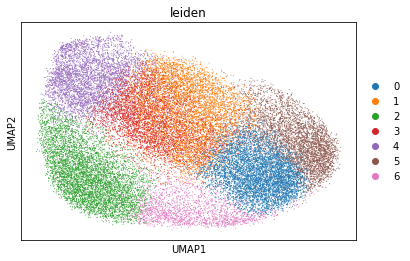

In [27]:
sc.pl.umap(svensson_10x_adata, color='leiden')

We see that there is indeed some heterogeneity in clusters, so they are not completely random, and we will see it indeed.

In [28]:
mean, zeros = return_mean_per(svensson_10x_adata.X)

In [29]:
random_svensson10x = create_random_count_matrix(svensson_10x_adata.X)
random_svensson10x_adata = sc.AnnData(X = random_svensson10x)
random_svensson10x_adata.var_names, random_svensson10x_adata.obs_names = svensson_10x_adata.var_names, svensson_10x_adata.obs_names

In [30]:
mean_random, zeros_random = return_mean_per(random_svensson10x)

In [31]:
sc.pp.pca(random_svensson10x_adata)
sc.pp.neighbors(random_svensson10x_adata, metric='cosine')
sc.tl.umap(random_svensson10x_adata)

In [32]:
df = pd.DataFrame({'m': np.log10(mean), 'z': zeros, 'n': svensson_10x_adata.var_names.values})
df_random = pd.DataFrame({'m': np.log10(mean_random), 'z': zeros_random, 'n': svensson_10x_adata.var_names.values})

p = figure(tools="box_zoom,hover,reset", plot_height=400, plot_width=400, tooltips=[("Gene","@n")])
p.scatter('m', 'z', source=df_random, color='#ababab', alpha=0.9)
p.scatter('m', 'z', source=df, color='firebrick', alpha=0.9)
show(p)

We see that even despite being *random*, the real distribution is not as the theoretical random distribution. We will later see those biases.

#### 10x neurons 10k

In [33]:
fastq_dir = "/media/seth/SETH_DATA/SETH_Alex/triku/data/10x/"

In [34]:
neurons_10k_adata = sc.read_10x_h5(fastq_dir + '/neuron_10k_v3_filtered_feature_bc_matrix.h5')
neurons_10k_adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [35]:
todense_arr = np.asarray(neurons_10k_adata.X.todense())

In [36]:
neurons_10k_adata = sc.AnnData(X = todense_arr, obs=pd.DataFrame(index=neurons_10k_adata.obs.index),
                   var=pd.DataFrame(index=neurons_10k_adata.var.index))

In [37]:
sc.pp.filter_genes(neurons_10k_adata, min_cells=20)
sc.pp.calculate_qc_metrics(neurons_10k_adata, inplace=True)
sc.pp.pca(neurons_10k_adata)
sc.pp.neighbors(neurons_10k_adata)
sc.tl.umap(neurons_10k_adata)
sc.tl.leiden(neurons_10k_adata)

In [38]:
mean, zeros = return_mean_per(neurons_10k_adata.X)

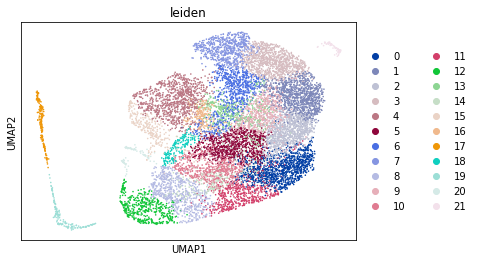

In [39]:
sc.pl.umap(neurons_10k_adata, color='leiden')

We see that there is indeed some heterogeneity in clusters, se they are not completely random, and we will see it indeed.

In [40]:
random_neurons10k = create_random_count_matrix(neurons_10k_adata.X)
random_neurons10k_adata = sc.AnnData(X = random_neurons10k)
random_neurons10k_adata.var_names, random_neurons10k_adata.obs_names = neurons_10k_adata.var_names, neurons_10k_adata.obs_names

In [41]:
mean_random, zeros_random = return_mean_per(random_neurons10k)

In [42]:
sc.pp.pca(random_neurons10k_adata)
sc.pp.neighbors(random_neurons10k_adata, metric='cosine')
sc.tl.umap(random_neurons10k_adata)

In [43]:
def NB_prop(mu, phi):
    return ((phi**(-1))/((phi**(-1))+mu))**(phi**(-1))

phi_exp_random, pcov = opt.curve_fit(NB_prop, mean_random, zeros_random)
phi_exp, pcov = opt.curve_fit(NB_prop, mean, zeros)

In [44]:
df = pd.DataFrame({'m': np.log10(mean), 'z': zeros, 'n': neurons_10k_adata.var_names.values})
df_random = pd.DataFrame({'m': np.log10(mean_random), 'z': zeros_random, 'n': neurons_10k_adata.var_names.values})

p = figure(tools="box_zoom,hover,reset", plot_height=400, plot_width=400, tooltips=[("Gene","@n")])
p.scatter('m', 'z', source=df_random, color='#ababab', alpha=0.7)
p.scatter('m', 'z', source=df, color='firebrick', alpha=0.7)

x_dots = np.linspace(np.log10(min(mean)), np.log10(max(mean)), 150)
p.line(x_dots, NB_prop(10**x_dots, phi_exp[0]), color='white')

x_dots = np.linspace(np.log10(min(mean_random)), np.log10(max(mean_random)), 150)
p.line(x_dots, NB_prop(10**x_dots, phi_exp_random[0]), color='black')

show(p)

In [47]:
neurons_10k_adata.uns['neighbors']['params']['n_neighbors']

15

# The rationale behind using kNN read counts
Highly variable genes are defined as genes with high variability of counts within a specific mean range. Those genes are used when doing downstream to reduce the dimensionality of the dataset, and select the most "informative" genes from the dataset. 

In the M3Drop pipeline, HVG selection is done considering the mean expression, and percentage of zeros. Theoretically, given a set of genes with similar genes, genes with a higher percentage of zeros concentrate their reads in a subset of cells, that is, there are more cells with fewer counts, whereas some cells have a higher read count. Generally, genes with higher percentage of zeros tend to have more expression in localized sets of cells, which results in a specific expression of the gene, and thus a biological function can be assumed to it. 

In this section we will study which distributions arise using the following method: for a selected mean gene count $\mu$, and a threshold $\epsilon$, we will consider the genes with mean expression in the range $(\mu - \epsilon, \mu + \epsilon)$. From those genes, we will consider the ones with the highest percentage of zeros, and the lowest percentage of zeros. We will see how the distribution of reads, and reads in the kNN follow (more or less closely) a binomial distribution, whereas for genes with higher percentage of zeros this does not follow.

In [43]:
def plot_distributions(adata, adata_random, mu, eps):
    mean_adata, per_adata = return_mean_per(adata.X)

    idx = (np.log10(mean_adata) > mu - eps)& (np.log10(mean_adata) < mu + eps)
    selected_genes = adata.var_names[idx]
    pers = per_adata[idx]
    min_gene, max_gene = selected_genes[np.argmin(pers)], selected_genes[np.argmax(pers)]
    
    knn_indices = return_knn_indices(adata.X)
    knn_counts, cat = return_expression_info([min_gene, max_gene], adata, knn_indices, category_name = 0)
    knn_indices_random = return_knn_indices(adata_random.X)
    knn_counts_random, cat = return_expression_info([min_gene, max_gene], adata_random, knn_indices, category_name = 0)
    
    fig = plt.figure(figsize=(14,8))
    ax1, ax2, ax3, ax4 = fig.add_subplot(241), fig.add_subplot(242), fig.add_subplot(243), fig.add_subplot(244)
    ax5, ax6, ax7, ax8 = fig.add_subplot(245), fig.add_subplot(246), fig.add_subplot(247), fig.add_subplot(248)
    
    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_yscale('log')
    nbins = 45
    
    # Plot with counts of gene near bottom
    ax1.set_title(min_gene + ' (~ random)  \ncount distribution')
    counts_gene_min = adata[:, min_gene].X.flatten()
    sns.distplot(counts_gene_min, kde=False, ax=ax1, bins=nbins)

        
    # Plot with counts of gene near bottom, but randomized
    ax2.set_title(min_gene + ' random \ncount distribution')
    counts_gene_min_random = adata_random[:, min_gene].X.flatten()
    sns.distplot(counts_gene_min_random, kde=False, ax=ax2, bins=nbins, color='red')

        
    # Plot with counts of gene at top
    ax3.set_title(max_gene + ' (not random) \ncount distribution')
    counts_gene_max = adata[:, max_gene].X.flatten()
    sns.distplot(counts_gene_max, kde=False, ax=ax3, bins=nbins)

    
    # Plot with counts of gene at top, but randomized
    ax4.set_title(max_gene + ' random \ncount distribution')
    counts_gene_max_random = adata_random[:, max_gene].X.flatten()
    sns.distplot(counts_gene_max_random, kde=False, ax=ax4, bins=nbins, color='red')
    
    
   
    # Plot with KNN counts of gene near bottom
    ax5.set_title(min_gene + ' (~ random) \nknn distribution')
    sns.distplot(knn_counts[min_gene], kde=False, ax=ax5, bins=nbins)  
    
    # Plot with KNN counts of gene near bottom, but randomized
    ax6.set_title(min_gene + ' random \nknn distribution')
    sns.distplot(knn_counts_random[min_gene], kde=False, ax=ax6, bins=nbins, color='red')
        
    # Plot with KNN counts of gene at top
    ax7.set_title(max_gene + ' (not random) \nknn distribution')
    counts_gene_max = adata[:, max_gene].X
    sns.distplot(knn_counts[max_gene], kde=False, ax=ax7, bins=nbins)

    
    # Plot with KNN counts of gene at top, but randomized
    ax8.set_title(max_gene + ' random \nknn distribution')
    sns.distplot(knn_counts_random[max_gene], kde=False, ax=ax8, bins=nbins, color='red')
    
    plt.tight_layout()
    
    sc.pl.umap(adata, color=[min_gene, max_gene], cmap=magma)
    sc.pl.umap(adata_random, color=[min_gene, max_gene], cmap=magma)

**How do we interpret the plot?**

On the first row we will calculate the **distribution of reads** in the dataset for the gene with smallest and biggest percentage of zeros. In blue appear the distributions of reads from the *biological* dataset, and in red for the random dataset. The pair of blue / red plots on the left represent the gene with smallest percentage of zeros, and the plots on the right represent the gene with highest percentage of zeros.
We generally see that for the *biological* dataset, the distributions of reads are more skewed.

The second row shows the distribution of reads for the kNN. To calculate the distribution of kNN, for each **cell with positive expression**, we consider their neighbors. The selection of cells with positive expression is arbritary, but for genes with low expression the resulting distributions are much more "real like", sice there is not an spike in zeros.

The third and fourth rows correspond to the UMAP representations of the *biological* and randomized adatas. We observe that, as usual, the randomized UMAP shows a random distribution of points.

### Distribution plotting on Svensson control

In [ ]:
plot_distributions(svensson_10x_adata, random_svensson10x_adata, -1.6, 0.05)

In [ ]:
plot_distributions(svensson_10x_adata, random_svensson10x_adata, -1.1, 0.05)

In [ ]:
plot_distributions(svensson_10x_adata, random_svensson10x_adata, -0.85, 0.05)

In [ ]:
plot_distributions(svensson_10x_adata, random_svensson10x_adata, -0.6, 0.05)

In [ ]:
plot_distributions(svensson_10x_adata, random_svensson10x_adata, 0, 0.05)

In [ ]:
plot_distributions(svensson_10x_adata, random_svensson10x_adata, 0.3, 0.05)

In [ ]:
plot_distributions(svensson_10x_adata, random_svensson10x_adata, 0.6, 0.05)

In [ ]:
plot_distributions(svensson_10x_adata, random_svensson10x_adata, 1, 0.05)

Since this dataset is composed of reads, and not of cells, we should expect a random *behaviour* of the genes. We see it is indeed the case: for all ranges the distributions of counts and kNN counts are similar, with the exception of some minor differences.

### Distribution plotting on Neurons 10k

In [ ]:
plot_distributions(neurons_10k_adata, random_neurons10k_adata, -1.6, 0.05)

In [ ]:
plot_distributions(neurons_10k_adata, random_neurons10k_adata, -1.1, 0.05)

In [ ]:
plot_distributions(neurons_10k_adata, random_neurons10k_adata, -0.85, 0.05)

In [ ]:
plot_distributions(neurons_10k_adata, random_neurons10k_adata, -0.6, 0.05)

In [ ]:
plot_distributions(neurons_10k_adata, random_neurons10k_adata, 0, 0.05)

In [ ]:
plot_distributions(neurons_10k_adata, random_neurons10k_adata, 0.3, 0.05)

In [ ]:
plot_distributions(neurons_10k_adata, random_neurons10k_adata, 0.6, 0.05)

In [ ]:
plot_distributions(neurons_10k_adata, random_neurons10k_adata, 1.6, 0.05)

We do see that the distribution of reads in the kNN of the gene with fewest percentage of zeros has, indeed, a similar distribution to the random dataset. This number is even more similar to the distribution in the random dataset when we evaluate genes with smaller mean expression. 

However, the distribution of reads in the kNN obtained from the random dataset is not really the same distribution as the one obtained from randomly sampling N cells and finding their distribution. In the next section we will reveal an approximation to that distribution, which is fair enough for the number of neighbors we are considering. 

# Wasserstein distance for comparison of distributions

Wasserstein distance is also known as Earth Mover Distance, due to the intuitive interpretation of the distance: given two distributions (or piles of earth) with the same area, the Wasserstein distance represents the minimum amount of mass that has to be moved to transform one distribution into the other. Wasserstein distance has been shown to outperform other distribution comparison metrics, such as KL or JS distances.

In this section we will apply some examples of the Wasserstein distance to get an intuition of its values, and then we will explain how it can be modified to account for distributions at different orders of magnitude.

## Wasserstein distance on toy examples

For this section we will in include examples of simple distributions, and see which are the distances.

The nomenclature of the function is 
`sts.wasserstein_distance(dist_range_1, dist_range_2, dist_height_1, dist_height_2)`
where `dist_range_1` and `dist_range_2` are the positions of the x axis of the distribution, and `dist_height_1` and `dist_height_2` are the heights (or frequencies) of the distributions at the x values.

In [ ]:
# Example 0: two equal distributions
d_0 = sts.wasserstein_distance([0, 1], [0, 1], [1, 1], [1, 1])

print('Wasserstein distance for equal distributions: {}'.format(d_0))

As expected, if the distributions are equal, the distance is 0.

In [ ]:
# Example 1 and 2: move a whole distribution 1 and 2 places
d_1 = sts.wasserstein_distance([0, 1], [1, 2], [1, 1], [1, 1])
print('Wasserstein distance for D1: {}'.format(d_1))

d_2 = sts.wasserstein_distance([0, 1], [2, 3], [1, 1], [1, 1])
print('Wasserstein distance for D1: {}'.format(d_2))

For `d_1` we have to move the pile at [1, 2] to [0, 1]. For that, the least expensive option is to move the block at 1 to 0, and the one at 2 to 1; or keep the block at 1 static and move the one at 2 to 0. In the first option we are moving $0.5\cdot 1 + 0.5\cdot 1 = 1$, and in the second we are moving $0.5 \cdot 0 + 0.5 \cdot 2 = 1$.

For `d_2` we are moving the whole distribution two positions, which is equivalent to moving it two times  ($0.5\cdot 2 + 0.5 \cdot 2 = 2$).

For the last part we are going to analyze the examples at scipy's documentation.

In [ ]:
d_3 = sts.wasserstein_distance([0, 1, 3], [5, 6, 8]) # We omit the heights of one
print('Wasserstein distance for D3: {}'.format(d_3))

d_4 = sts.wasserstein_distance([0, 1], [0, 1], [3, 1], [2, 2])
print('Wasserstein distance for D4: {}'.format(d_4))

In the third example we are moving a distribution with three blocks from one position to another. We see that both distributions are the same, but shifted 5 positions. Therefore, we have moved the distribution 5 times.

In the fourth example we have two distributions of four blocks, and to move the first one into the second one, we have to move one block from 0 to 1. Since we have moved 1 block out of 4, the total weight moved is a 25% of the distribution and, thus, `d_4 = 0.25`.

Therefore, we do see that the intuition of the Wasserstein distance is how many times the distribution has to be moved to convert into the second one.

## Wasserstein on different scales

Distribution of read counts or kNN counts on single cell vary in a wide scale, ranging from units to thousands of units of difference. This is a problem, because distributions at higher orders of magnitude have higher distances, and thus Wasserstein distance will scale linearly with the scale of the distribution.

To see that, we will calculate the Wasserstein distance for two cases of normal distributions:
* $N(0,1)$ VS $N(5,1)$
* $N(0, 100)$ VS $(500, 100)$

In [ ]:
sts.wasserstein_distance(sts.norm.rvs(0, 1, 100000), sts.norm.rvs(5, 1, 100000))

In [ ]:
sts.wasserstein_distance(sts.norm.rvs(0, 100, 100000), sts.norm.rvs(500, 100, 100000))

We clearly see that the distribution increases linearly with the scale, and also, with the standard deviation.
Therefore, we can *scale* down the distribution if we divide it by the standard distribution of one of the two functions. This way, we still have the sense of how many times the distribution has to be moved, without considering the scale.

In [ ]:
sts.wasserstein_distance(sts.norm.rvs(0, 1, 100000), sts.norm.rvs(5, 1, 100000)) / np.std(sts.norm.rvs(0, 1, 100000))

In [ ]:
sts.wasserstein_distance(sts.norm.rvs(0, 100, 100000), sts.norm.rvs(500, 100, 100000)) / np.std(sts.norm.rvs(0, 100, 100000))

Since, for our case, we have to compare the distribution obtained by convoluting the reads from a gene kNN times, which is the *theoretical distribution* to the distribution of kNN reads, we will choose the standard distribution of the theoretical distribution to calculate the distance.

# Approximating the distribution of reads in N random cells

In the following sections we will analyze how can we model the distribution of kNN reads given a prior distribution. This will be interesting, because we can later analyze the difference between the theoretical distribution and the *real* one.


Let's imagine a dataset with $C$ cells, $N$ of which are selected, and their number of reads are counted. Let's suppose that the number of counts follows a distribution $X$. 

The distribution of reads in 1 cell is, simply, the distribution $X$, which we will also call $X_1$. The distribution of reads given 2 cells, or $X_2$ is the *sum* of the two distributions. 

We will see an example of that sum. Let's suppose that $X_1$ is described as follows: (proportions are relative to 1 to make calculations easier).

$P(X_1 = 1) = 1; P(X_1 = 2) = 3; P(X_1 = 3) = 7; P(X_1 = 4) = 5; P(X_1 = 5) = 2; P(X_1 = 6) = 1$

In order to calculate the distribution of $X_2$, we will see an example of some values:

* $P(X_2 = 2) = P(X_1 = 1) \cdot P(X_1 = 1) = 1$
* $P(X_2 = 4) = P(X_1 = 2) \cdot P(X_1 = 2) + P(X_1 = 1) \cdot P(X_1 = 3) +  P(X_1 = 3) \cdot P(X_1 = 1) = 3\cdot 3 + 2\cdot(7\cdot1) = 23$
* $P(X_2 = 9) = P(X_1 = 6) \cdot P(X_1 = 3) + P(X_1 = 3) \cdot P(X_1 = 6) + P(X_1 = 5) \cdot P(X_1 = 4) + P(X_1 = 4) \cdot P(X_1 = 5) = 2\cdot(1\cdot 7 + 2\cdot5) = 34$

In the case of $P(X_1 = 2) \cdot P(X_1 = 2)$ we should technically do $P(X_1 = 2) \cdot (P(X_1 = 2) - 1)$, since one of the elements has already been chosen. However, we will ignore this fact to make the operations easier.

So, if we want to generalize the sum to $P(X_2 = k)$, then, we have to find all pairs $(a,b)$ such that $a + b =k$, and compute the sum of events. This *sum* is called convolution, that is, the distribution arosen from all the combination of elements from the distribution $X$. Mathematically, given two probability distributions 
$f,g$, the convolution of $f$ in $g$ for a value $k$ is:

$$ (f*g)[k] = \sum_{m = -\infty}^{\infty} f[m]g[k-m] $$

In this case $m$ will be bounded between 1 and 6. 


## Why counting kNN reads from cells with positive expression is better
When counting the reads from the kNN we can consider the reads in kNN from cells with zero counts, or exclude them. That is, if we have the distribution of counts:

$P(X_1 = 0) = 0.9, P(X_1 = 1) = 0.05, P(X_1 = 2) = 0.03, P(X_1 = 3) = 0.015, P(X_1 = 4) = 0.005$

We consider the distribution $X_1^*$:

$P(X_1 = 1) = 0.5 , P(X_1 = 2) = 0.3, P(X_1 = 3) = 0.15, P(X_1 = 4) = 0.05$

Which is the one obtained after removing $P(X_1 = 0) = 0.9$ and adjusting the proportions to sum to 1. 

The first iteration, that is, the distribution of reads, is $X_1^*$; then the distribution of reads for two cells is $X_2^* = X_1^**X_1$, and, for $N$ reads, the final distribution of reads is $X_N^* = X_1^**X_1*\cdots_{n-1}*X_1$. For genes with larger expression values the difference between $X^*_N$ and $X_N$ are not that relevant, but for genes with few counts, it becomes relevant. In the next cell we will calculate $X^*_N$ and $X_N$ for genes with low and high counts, and
we will see that $X^*_N$ sometimes is the best fitting ditribution. 

The rationale behind considering reads with positive counts is that for genes with low expression, the differences become more apparent with high percentage of zeros, and remain similar with lower percentages of zeros. Also, genes with high expression will not be affected by this measure. This thus should favor the selection of genes with lower expression, which sometimes can be neglected.

To show that, we are going to use a distance (we will explain which one later on) and genes with low, low-mid, mid and high expression; based on having a low or high percentage of zeros.  

In [49]:
list_genes = ['Tpcn2', 'Pex11g', 'Rgs1', 'Rac2', 'Usp20',
              'Cln8', 'Spp1', 'Vwa1', 'Rbm6', 'Ogt', 
             'Pcp4', 'Opcml', 'Rsrp1', 'mt-Nd4', 'Tubb2a', 'Tubb3']

In [50]:
adata = neurons_10k_adata.copy()
knn = int(0.5 * adata.X.shape[0] ** 0.5)
knn_indices_knn_norm = return_knn_indices(adata.X, knn=knn, return_random=False) 
expression_counts_knn_norm, categories = return_expression_info(list_genes, adata, 
                                                                           knn_indices_knn_norm, 
                                                           category_name = 0, zero_counts=False)


expression_counts_knn_norm_with_zeros, categories = return_expression_info(list_genes, adata, 
                                                                           knn_indices_knn_norm, 
                                                           category_name = 0, zero_counts=True)

2020-04-15 19:43:18,385	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-04-15 19:43:18,389	INFO resource_spec.py:212 -- Starting Ray with 449.46 GiB memory available for workers and up to 18.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-15 19:43:20,055	INFO services.py:1078 -- View the Ray dashboard at localhost:8265
2020-04-15 19:43:23,080	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-04-15 19:43:23,082	INFO resource_spec.py:212 -- Starting Ray with 449.37 GiB memory available for workers and up to 18.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-15 19:43:24,611	INFO services.py:1078 -- View the Ray dashboard at localhost:8265


In [71]:
%%timeit
knn_indices_knn_norm = return_knn_indices(adata.X, knn=knn, return_random=False) 

23.4 s ± 92.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [72]:
%%timeit
sc.pp.neighbors(adata, n_neighbors=knn)

10.3 s ± 46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# Those are genes with high percentage of zeros
# Rac2 - Low expression
# Vwa1 - Low-mid expression
# Opcml - Mid expression
# Tubb2a - High expression

for gene in ['Rac2', 'Vwa1', 'Opcml', 'Tubb2a', 
             ]:
    compare_zeros_non_zeros(gene, adata, 
        expression_counts_knn_norm, 
        expression_counts_knn_norm_with_zeros)

In [ ]:
# Those are genes with low percentage of zeros
# Tpcn2 - Low expression
# Usp20 - Low-mid expression
# Rbm6 - Mid expression
# Rsrp1 - High expression

for gene in ['Tpcn2',  'Usp20', 'Rbm6',  'Rsrp1',]:
    compare_zeros_non_zeros(gene, adata, 
        expression_counts_knn_norm, 
        expression_counts_knn_norm_with_zeros)

We see that using the kNN reads of positively-expressed cells, the distances and the plots at lower expressions become more clear, whereas for high expression genes the differences are not so apparent. We also see that for genes with lower percentage of zeros, that is, which are expected to behave like *random* expressing genes, do not show that much difference between including or not zero-expressing cells, which should be expected.

In [ ]:
list_genes = ['CCDC82', 'CAV1', 'PFDN1', 'ATP5MC2', 'RPL34', 'MT-ND2', 'MT-RNR2', 'MBP', 'UBB'] # Svensson
list_genes = ['Ubiad1', 'Rspo1', 'Cog3', 'Lyz2', 'Zfp688', 'Ccl3', 'Gpr107', 'Vtn', 'Dhx30', 'Sparc', 'Rbm25',
             'Opcml', 'Neurod2', 'Ptma', 'Eef1a1', 
             'Cbarp', 'Pdlim4', 'Vim', 'Hmgb2', 'Ccl2', 'Csf1', 'Mmab', 'Pecam1', 'Gja1', 'Rims4'] # Neuron 10x
list_genes = ['Ccl12', 'Rac2', 'Tap1', 'Disp1', 'Zic1', 'Eva1b', 'Zfp3', 'Fbxl20', 'Clic1', 'Jun', 
              'Clk4', 'Tra2a', 'Meis2', 'Tubb3', 'Rsrp1', 'mt-Nd4', 'Malat1', 'Ppia', 'mt-Co1', 'mt-Co3']

In [ ]:
adata = neurons_10k_adata.copy()
knn = int(0.5 * adata.X.shape[0] ** 0.5)
knn_indices_adata_norm_knn_norm = return_knn_indices(adata.X, knn=knn, return_random=False) 
expression_counts_adata_norm_knn_norm, categories = return_expression_info(list_genes, adata, 
                                                                           knn_indices_adata_norm_knn_norm, 
                                                           category_name = 0)


knn_indices_adata_norm_knn_random = return_knn_indices(adata.X, knn=knn, return_random=True) 
expression_counts_adata_norm_knn_random, categories = return_expression_info(list_genes, adata, 
                                                                           knn_indices_adata_norm_knn_random, 
                                                           category_name = 0)



adata_random = random_neurons10k_adata.copy()
knn = int(0.5 * adata.X.shape[0] ** 0.5)
knn_indices_adata_random_knn_norm = return_knn_indices(adata_random.X, knn=knn, return_random=False) 
expression_counts_adata_random_knn_norm, categories = return_expression_info(list_genes, adata_random, 
                                                                           knn_indices_adata_random_knn_norm, 
                                                           category_name = 0)


knn_indices_adata_random_knn_random = return_knn_indices(adata_random.X, knn=knn, return_random=True) 
expression_counts_adata_random_knn_random, categories = return_expression_info(list_genes, adata_random, 
                                                                           knn_indices_adata_random_knn_random, 
                                                           category_name = 0)


To see how well does the convolution fit the real kNN distribution, we are going to plot the following plot for several genes. The plot consists of 3 columns and 2 rows.

**Rows**: first row contains results using the original adata, and second row contains results using the randomised adata.

**Columns**: 
* First column contains the read counts
* Second column contains the counts of a random selection of NN per cell.
* Third column contains the counts of the kNN based on cosine distance.

To see the effect of the mean number of read counts and the percentage of zeros, we are going to do the plot for
5 categories of means (low [-2.5, -1.5], low-mid [-1.5, -0.5], mid [-0.5, 0.5], mid-high [0.5, 1.5] and high [1.5, 2.5]), and 2 categories of percentage of zeros (high and low).

Looking at the graph of percentage of zeros VS mean read count, at high and low means there should be not that much difference between high and low percentages of zeros.

### LOW mean, HIGH percentage of zeros

In [ ]:
plot_convolution('Rac2', adata, expression_counts_adata_norm_knn_norm, expression_counts_adata_norm_knn_random,
                     adata_random, expression_counts_adata_random_knn_norm, expression_counts_adata_random_knn_random)

### LOW mean, LOW percentage of zeros

In [ ]:
plot_convolution('Tap1', adata, expression_counts_adata_norm_knn_norm, expression_counts_adata_norm_knn_random,
                     adata_random, expression_counts_adata_random_knn_norm, expression_counts_adata_random_knn_random)

### LOW-MID mean, HIGH percentage of zeros

In [ ]:
plot_convolution('Zic1', adata, expression_counts_adata_norm_knn_norm, expression_counts_adata_norm_knn_random,
                     adata_random, expression_counts_adata_random_knn_norm, expression_counts_adata_random_knn_random)

### LOW-MID mean, LOW percentage of zeros

In [ ]:
plot_convolution('Fbxl20', adata, expression_counts_adata_norm_knn_norm, expression_counts_adata_norm_knn_random,
                     adata_random, expression_counts_adata_random_knn_norm, expression_counts_adata_random_knn_random)

### MID mean, HIGH percentage of zeros

In [ ]:
plot_convolution('Clic1', adata, expression_counts_adata_norm_knn_norm, expression_counts_adata_norm_knn_random,
                     adata_random, expression_counts_adata_random_knn_norm, expression_counts_adata_random_knn_random)

### MID mean, LOW percentage of zeros

plot_convolution('Rac2', adata, expression_counts_adata_norm_knn_norm, expression_counts_adata_norm_knn_random,
                     adata_random, expression_counts_adata_random_knn_norm, expression_counts_adata_random_knn_random)

In [ ]:
plot_convolution('Clk4', adata, expression_counts_adata_norm_knn_norm, expression_counts_adata_norm_knn_random,
                     adata_random, expression_counts_adata_random_knn_norm, expression_counts_adata_random_knn_random)

### MID-HIGH mean, HIGH percentage of zeros

In [ ]:
plot_convolution('Meis2', adata, expression_counts_adata_norm_knn_norm, expression_counts_adata_norm_knn_random,
                     adata_random, expression_counts_adata_random_knn_norm, expression_counts_adata_random_knn_random)

### MID-HIGH mean, LOW percentage of zeros

In [ ]:
plot_convolution('Rsrp1', adata, expression_counts_adata_norm_knn_norm, expression_counts_adata_norm_knn_random,
                     adata_random, expression_counts_adata_random_knn_norm, expression_counts_adata_random_knn_random)

### HIGH mean, HIGH percentage of zeros

In [ ]:
plot_convolution('Malat1', adata, expression_counts_adata_norm_knn_norm, expression_counts_adata_norm_knn_random,
                     adata_random, expression_counts_adata_random_knn_norm, expression_counts_adata_random_knn_random)

### HIGH mean, LOW percentage of zeros

In [ ]:
plot_convolution('mt-Co1', adata, expression_counts_adata_norm_knn_norm, expression_counts_adata_norm_knn_random,
                     adata_random, expression_counts_adata_random_knn_norm, expression_counts_adata_random_knn_random)

# Correcting for non-random kNN in random datasets

When calculating the distribution with the convolution, two assumptions are made. First, reads are randomly distributed across cells. Second, the kNN are chosen at random (in this case it would be nicer to say k random cells instead of random kNN, but we will stick to that definition). 

In [ ]:
def create_random_sample(n_cells, n_genes):
    knn = int((n_cells ** 0.5))

    xoxo = create_random_count_matrix(n_cells = n_cells, n_genes = n_genes, 
                                      n_min_reads = int(0.01 * n_cells), n_max_reads = int(300 * n_cells))

    print('knn_random')
    knn_indices_random = return_knn_indices(xoxo, knn=knn, return_random=True) 
    print('knn')
    knn_indices = return_knn_indices(xoxo, knn=knn, return_random=False) 

    ray.init(ignore_reinit_error=True)
    print('c')
    list_idx_genes = np.arange(n_genes)
    obj_ids = ray.get([return_expression_info_per_gene.remote(gene_idx=list_idx_genes[i], 
                                adata_X=xoxo, knn_indices=knn_indices, zero_counts=False,
                                                            fill_zeros=False) for i in range(len(list_idx_genes))])
    print('v')
    obj_ids_random = ray.get([return_expression_info_per_gene.remote(gene_idx=list_idx_genes[i], 
                                adata_X=xoxo, knn_indices=knn_indices_random, zero_counts=False, 
                                                                    fill_zeros=False) for i in 
                              range(len(list_idx_genes))])
    ray.shutdown()
    
    return xoxo, obj_ids, obj_ids_random

In [ ]:
matrix, obj_ids, obj_ids_random = create_random_sample(1000, 3000)

In [ ]:
for idx in tqdm(range(1000)):
    counts_idx = matrix[:, idx]
    counts_knn = obj_ids[idx]
    counts_knn_random = obj_ids_random[idx]
    
    x_counts, y_counts = np.unique(counts_idx, return_counts=True)
    d_c = sts.rv_discrete(a=0, b=len(counts_idx), values=(x_counts, y_counts/sum(y_counts)))
    distribution_corrected, _ = apply_convolution_read_counts(d_c, knn = knn, threshold = 1, correct=True)
    
    
    EMD_dist_knn = EMD(counts_knn, distribution_corrected)

In [ ]:
distribution_corrected.pmf(3000)

In [ ]:
idx = 990
print(knn)
counts_idx = matrix[:, idx]
counts_knn = obj_ids[idx]
counts_knn_random = obj_ids_random[idx]


x_counts, y_counts = np.unique(counts_idx, return_counts=True)
d_c = sts.rv_discrete(a=0, b=len(counts_idx), values=(x_counts, y_counts/sum(y_counts)))
distribution_corrected, _ = apply_convolution_read_counts(d_c, knn = knn, threshold = 1, correct=True)

range_ax = np.arange(int(0.9 * min(counts_knn)), int(1.1 * max(counts_knn)))

_ = plt.hist(counts_knn.tolist(), density=True, bins=int(max(counts_knn) - min(counts_knn)), alpha=0.8, 
            label='non-random')
_ = plt.hist(counts_knn_random.tolist(), density=True, bins=int(max(counts_knn_random) - min(counts_knn_random)), alpha=0.8, 
            label='random')

plt.legend()
plt.plot(range_ax + 0.5, distribution_corrected.pmf(range_ax), label='corrected')

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
sns.clustermap(cosine_similarity(adata_random.X[::10, :]))

In [ ]:
sns.clustermap(np.log10(adata_random.X[::10, ::20] + 1))

In [ ]:
sns.distplot(adata_random.X[:, :].sum(1))

**NOTE**

We have seen that the distribution of $X_N$ (or $X^*_N$ if we want to be more correct) is the number of reads found in $N$ cells. There is a caveat: technically, $X_i$ should consider that $i-1$ cells are absent from the dataset, since they have already be taken (their counts have already be summed to the total), and thus the convolution should not consider those cells. However, this drastically increases the computation, since we have to consider the convolution after removing all combinations of $i$ cells. For big $N$ this might be a problem, but for small $N$, which is the case ($N \sim \sqrt{C}$), the convolution is a fair approximation to the real distribution.

# Plotting Wasserstein distance on all genes

In [ ]:
np.random.seed(0)
adata = neurons_10k_adata.copy()
list_genes = adata.var_names.values
knn = int(0.5 * adata.X.shape[0] ** 0.5)
N = len(adata.var_names) - 1

In [ ]:
knn_indices_adata_norm_knn_norm = return_knn_indices(adata.X, knn=knn, return_random=False) 
expression_counts_adata_norm_knn_norm, categories = return_expression_info(list_genes[:N], adata, 
                                                                           knn_indices_adata_norm_knn_norm, 
                                                           category_name = 0)


knn_indices_adata_norm_knn_random = return_knn_indices(adata.X, knn=knn, return_random=True) 
expression_counts_adata_norm_knn_random, categories = return_expression_info(list_genes[:N], adata, 
                                                                           knn_indices_adata_norm_knn_random, 
                                                           category_name = 0)



adata_random = random_neurons10k_adata.copy()
knn = int(0.5 * adata.X.shape[0] ** 0.5)
knn_indices_adata_random_knn_norm = return_knn_indices(adata_random.X, knn=knn, return_random=False) 
expression_counts_adata_random_knn_norm, categories = return_expression_info(list_genes[:N], adata_random, 
                                                                           knn_indices_adata_random_knn_norm, 
                                                           category_name = 0)


knn_indices_adata_random_knn_random = return_knn_indices(adata_random.X, knn=knn, return_random=True) 
expression_counts_adata_random_knn_random, categories = return_expression_info(list_genes[:N], adata_random, 
                                                                           knn_indices_adata_random_knn_random, 
                                                           category_name = 0)

In [ ]:
@ray.remote
def compute_convs(adata, adata_random, gene, 
                 expression_counts_adata_norm_knn_norm, 
                 expression_counts_adata_norm_knn_random,
                 expression_counts_adata_random_knn_norm, 
                 expression_counts_adata_random_knn_random,):
    
    counts_gene = adata[:, gene].X.ravel()
    x_counts, y_counts = np.unique(counts_gene, return_counts=True)
    d_c = sts.rv_discrete(a=0, b=len(counts_gene), values=(x_counts, y_counts/sum(y_counts)))
    convolution, _ = apply_convolution_read_counts(d_c, knn=knn, threshold = 1)
    
    
    counts_gene_random = adata_random[:, gene].X.ravel()
    x_counts_random, y_counts_random = np.unique(counts_gene_random, return_counts=True)
    d_c_random = sts.rv_discrete(a=0, b=len(counts_gene_random), values=(x_counts, y_counts/sum(y_counts)))
    convolution_random, _ = apply_convolution_read_counts(d_c_random, knn=knn, threshold = 1)
    
    
    EMD_N_N = EMD(expression_counts_adata_norm_knn_norm[gene], convolution) 
    EMD_N_R = EMD(expression_counts_adata_norm_knn_random[gene], convolution)
    EMD_R_N = EMD(expression_counts_adata_random_knn_norm[gene], convolution_random)
    EMD_R_R = EMD(expression_counts_adata_random_knn_random[gene], convolution_random)
    
    return EMD_N_N, EMD_N_R, EMD_R_N, EMD_R_R


ray.shutdown()
ray.init()

adata_obj = ray.put(adata)
adata_random_obj = ray.put(adata_random)
expression_counts_adata_norm_knn_norm_id = ray.put(expression_counts_adata_norm_knn_norm)
expression_counts_adata_norm_knn_random_id = ray.put(expression_counts_adata_norm_knn_random)
expression_counts_adata_random_knn_norm_id = ray.put(expression_counts_adata_random_knn_norm)
expression_counts_adata_random_knn_random_id = ray.put(expression_counts_adata_random_knn_random)

ray_obj_ids = [compute_convs.remote(adata_obj, adata_random_obj, gene, 
                                     expression_counts_adata_norm_knn_norm_id, 
                                     expression_counts_adata_norm_knn_random_id,
                                     expression_counts_adata_random_knn_norm_id, 
                                     expression_counts_adata_random_knn_random_id,
                                   ) for gene in list_genes[:N]]
ray_objs = ray.get(ray_obj_ids)


list_D_adata_knn, list_D_adata_knn_random, list_D_adata_random_knn, list_D_adata_random_knn_random = [], [], [], []

list_D_adata_knn = [x[0] for x in ray_objs]
list_D_adata_knn_random = [x[1] for x in ray_objs]
list_D_adata_random_knn = [x[2] for x in ray_objs]
list_D_adata_random_knn_random = [x[3] for x in ray_objs]

In [ ]:
df = pd.DataFrame({'x': [0]*len(list_genes[:N])+[1]*len(list_genes[:N])+[2]*len(list_genes[:N])+[3]*len(list_genes[:N]) , 
                   'y': list_D_adata_knn + list_D_adata_knn_random + list_D_adata_random_knn + list_D_adata_random_knn_random})


sns.swarmplot(x='x', y='y', data=df.loc[np.random.choice(np.arange(4*N), 1000)])

In [ ]:
list_mean_exp, list_p_zeros = return_mean_per(adata[:, list_genes[:N]].X)
df_bokeh = pd.DataFrame({'m': np.log10(list_mean_exp), 'z': list_p_zeros, 'n': list_genes[:N], 
                   'd':list_D_adata_knn, 
                         'r':np.array(list_D_adata_random_knn) / np.array(list_D_adata_knn),
                         'e':np.array(list_D_adata_knn) - np.array(list_D_adata_random_knn_random)})[:2900]

In [ ]:
# Uncorrected distances

p = figure(tools="box_zoom,hover,reset", plot_height=400, plot_width=400, tooltips=[("Gene","@n"), ('Value', '@d')])

color_map = LinearColorMapper(low=min(df_bokeh.d.values), 
                              high=np.percentile(df_bokeh.d.values, 95), palette='Viridis256')


p.scatter('m', 'z', source=df_bokeh, fill_color={'field': 'd', 'transform':color_map}, 
          alpha=0.7, line_color=None)

from bokeh.models import ColorBar
bar = ColorBar(color_mapper=color_map, location=(0,0))
p.add_layout(bar, "left")
show(p)

In [ ]:
# Corrected distances

p = figure(tools="box_zoom,hover,reset", plot_height=400, plot_width=400, tooltips=[("Gene","@n"), ('Value', '@e')])

color_map = LinearColorMapper(low=min(df_bokeh.d.values), 
                              high=np.percentile(df_bokeh.d.values, 95), palette='Viridis256')


p.scatter('m', 'z', source=df_bokeh, fill_color={'field': 'e', 'transform':color_map}, 
          alpha=0.7, line_color=None)

from bokeh.models import ColorBar
bar = ColorBar(color_mapper=color_map, location=(0,0))
p.add_layout(bar, "left")
show(p)

In [ ]:
# Proportion of change (random_dist / uncorrected_dist)

p = figure(tools="box_zoom,hover,reset", plot_height=400, plot_width=400, tooltips=[("Gene","@n"), ('Correction proportion', '@r')])

color_map = LinearColorMapper(low=min(df_bokeh.r.values), 
                              high=np.percentile(df_bokeh.r.values, 95), palette='Viridis256')


p.scatter('m', 'z', source=df_bokeh, fill_color={'field': 'r', 'transform':color_map}, 
          alpha=0.7, line_color=None)

from bokeh.models import ColorBar
bar = ColorBar(color_mapper=color_map, location=(0,0))
p.add_layout(bar, "left")
show(p)

In [ ]:
for i in tqdm(range(0, len(list_mean_exp), 10)):
    x = np.log10(list_mean_exp)[i]
    y0 = np.array(list_D_adata_random_knn)[i]
    yf = np.array(list_D_adata_knn)[i]
    
    plt.plot([x,x], [np.log10(y0+1), np.log10(yf+1)], 
             c='#ababab', linewidth=1, alpha=0.01)
    
    
    plt.scatter(x, np.log10(y0+1), c='#007ab7', s=5, alpha=0.8)
    plt.scatter(x, np.log10(yf+1), c='#c62d42', s=5, alpha=0.8)

   
plt.xlabel('log$_{10}$(mean expression)')
plt.ylabel('log$_{10}$(Wasserstein distance + 1)')

In [ ]:
arr_ratios = np.array(list_D_adata_random_knn) / np.array(list_D_adata_knn)
arr_ratios[arr_ratios > 1] = 1
plt.scatter(np.log10(list_mean_exp), arr_ratios, )

plt.xlabel('log$_{10}$(mean expression)')
plt.ylabel('log$_{10}$(Wasserstein distance + 1)')

The genes with highest difference in distance fall in two categories.
* Genes with low expression and low percentage of low percentage of ceros. Their distributions fit the expected ones (their distance thus is small), and the distribution with the random adata has a small deviation from the expected one. Those cases are uninteresting because they are already genes with low expression and with no kNN expression.
* Genes with high expression (top 5%), and where the expected kNN read distribution from the randomized adata differs with the real one. We will see that those cases will not be considered as HVG,and this difference can somewhat be disregarded. Nontheless, it can be interesting to consider it just in case.

In [ ]:
sns.distplot(expression_counts_adata_norm_knn_norm['Tshz2'])

In [ ]:
gene = 'Tshz2'
plot_convolution(gene, adata, expression_counts_adata_norm_knn_norm, expression_counts_adata_norm_knn_random,
                     adata_random, expression_counts_adata_random_knn_norm, 
                 expression_counts_adata_random_knn_random)

sum_counts = np.zeros(len(adata))
sum_counts[adata[:, gene].X.flatten() > 0] = expression_counts_adata_norm_knn_norm[gene]
adata.obs['knn'] = sum_counts


sc.pl.umap(adata, color=[gene, 'knn'], cmap=magma)

# Select best genes
Now that all scores have been calculated, we are going to select the genest with the highest distance. For that we plot the mean (X) and the distance(Y).

In [ ]:
def substract_median(x, y, n_windows=15):
    linspace = np.linspace(min(x), max(x), n_windows+1)
    y_adjust = y.copy()
    
    for i in range(n_windows):
        mask = (x >= linspace[i]) & (x <= linspace[i+1])
        y_adjust[mask] -= np.median(y[mask])
        
    return y_adjust

In [ ]:
df_bokeh = pd.DataFrame({
    'm': np.log10(list_mean_exp), 
    'z': list_p_zeros, 
    'n': list_genes[:N], 
    'd': list_D_adata_knn, 
    'e': np.array(list_D_adata_knn) - np.array(list_D_adata_random_knn_random), 
    })[:]

df_bokeh['e_correct'] = substract_median(df_bokeh['m'].values, df_bokeh['e'].values, 100)

The plot on the left shows the corrected distances with respect to their mean. Interestingly, the genes with highest mean have a non-zero distance, but also no variation. To correct that skewness, we are going to 
*normalize* the distance to a baseline level. This baseline level will be calculated by calculated the median distance across a window of mean of expressions. 

In this way we will keep genes with distances above a baseline level, which are the interesting ones. This *normalized* plot the one on the right.

In [ ]:
p = figure(tools="box_zoom,hover,reset", plot_height=400, plot_width=400, tooltips=[("Gene","@n"), ('Value', '@e')])

p.scatter('m', 'e', source=df_bokeh,  alpha=0.7, line_color=None)

show(p)

In [ ]:
p = figure(tools="box_zoom,hover,reset", plot_height=400, plot_width=400, tooltips=[("Gene","@n"), ('Value', '@e')])

p.scatter('m', 'e_correct', source=df_bokeh,  alpha=0.7, line_color=None)

show(p)

The next step is to select the genes with highest distance. This can be chosen arbitrarily (select the N highest values), or by finding a inflexion point. This inflexion point could be interpreted as the point where the density of points, mapped to the Y-axis, increases. To calculate the cutoff, we are going to plot a rank of the distances (from lowest to highest) VS the distance. This curve has the common hockey-stick shape, and to calculate the *curving point* we are going to select the point of the curve with highest distance to the straight line that joins the two extremes on the curve.

 The distance between the straight line and a point $(u, v)$ con the curve can be expressed as the following optimization problem. Given the straight line with coordinates $(x, mx + b)$, the distance between $(u, v)$ and the line is the distance to the point $(x, mx+b)$ that minimizes its distance. If we consider the square of the distance, to simplify the problem, the optimal point $(x_{opt}, mx_{opt} + b)$ is
 
 $$x_{opt} = \frac{u - mb + mv}{1+m^2}$$

In [218]:
# we are going to select the best genes, which are located at the inflexion point in that curve

def get_cutoff_curve(y, S = 0.1):
    # Plots a curve, and finds the best point by joining the extremes of the curve with a line, and selecting
    # the point from the curve with the greatest distance.
    # The distance between a point in a curve, and the straight line is set by the followin equation
    # if u,v is the point in the curve, and y = mx + b is the line, then
    # x_opt = (u - mb + mv) / (1 + m^2)
    
    plt.plot(np.arange(len(y)), np.sort(y))
    
    min_y, max_y = np.min(y), np.max(y)
    m, b = (max_y - min_y) / len(y), min_y
    
    list_d = []
    
    for u, v in enumerate(np.sort(y)):
        x_opt = (u - m * b + m * v) / (1 + m ** 2)
        y_opt = x_opt * m + b
        d = (x_opt - u) ** 2 + (y_opt - v) ** 2
        
        list_d.append(d)

    
    # S is a corrector factor. It leverages the best value in the curve, and selects a more or less stringent
    # value in the curve. the maximum distance is multiplied by (1 - S), and the leftmost or rightmost index
    # is selected
    
    dist_S = (1 - np.abs(S)) * np.max(list_d)
    S_idx = np.argwhere(list_d >= dist_S)
    
    if S >= 0:
        max_d_idx = np.max(S_idx)
    if S < 0:
        max_d_idx = np.min(S_idx)
        
    plt.scatter(max_d_idx, np.sort(y)[max_d_idx])
    
    plt.xlabel("Rank of genes by Wasserstein distance")
    plt.ylabel("Wasserstein distance")
    
    return np.sort(y)[max_d_idx]

When implementing the algorithm to calculate the cutoff point, we have added the parameter $S$, $0 < |S| < 1$, which allows to adjust that cutoff point to choose fewer or more genes. If $D$ is the highest distance between the straight line and the curve, we calculate the *new* distance as $D\cdot |S|$. If $S > 0$, then we will select the point highest on the rank such that its distance is greater than $D\cdot |S|$, thus selecting fewer genes. Vice-versa if $S < 0$.

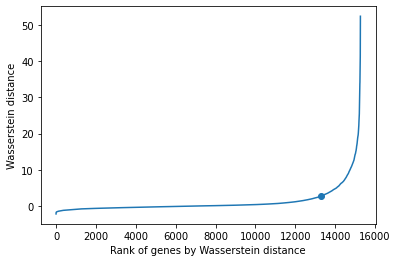

In [311]:
y_cutoff = get_cutoff_curve(df_bokeh['e_correct'].values, S=-0.025)    
df_bokeh['color'] = ["#ababab" if y < y_cutoff else "#007ab7" for y in df_bokeh['e_correct'].values]


On the left, the selected genes before correcting for baseline; and on the right after correcting. 

In [ ]:
p = figure(tools="box_zoom,hover,reset", plot_height=400, plot_width=400, tooltips=[("Gene","@n"), ('Value', '@e')])

color_map = LinearColorMapper(low=min(df_bokeh.d.values), 
                              high=np.percentile(df_bokeh.d.values, 90), palette='Viridis256')


p.scatter('m', 'e', source=df_bokeh,  
          alpha=0.7, line_color=None, 
         color='color')

show(p)

In [ ]:
p = figure(tools="box_zoom,hover,reset", plot_height=400, plot_width=400, tooltips=[("Gene","@n"), ('Value', '@e')])

color_map = LinearColorMapper(low=min(df_bokeh.d.values), 
                              high=np.percentile(df_bokeh.d.values, 90), palette='Viridis256')


p.scatter('m', 'e_correct', source=df_bokeh, 
          alpha=0.7, line_color=None, 
         color='color')

show(p)

Points mapped to the curve of percentage of zeros VS mean.

In [ ]:
p = figure(tools="box_zoom,hover,reset", plot_height=400, plot_width=400, tooltips=[("Gene","@n"), ('Value', '@e')])

color_map = LinearColorMapper(low=min(df_bokeh.d.values), 
                              high=np.percentile(df_bokeh.d.values, 90), palette='Viridis256')

p.scatter('m', 'z', source=df_bokeh, fill_color='color', alpha=0.7, line_color=None)

show(p)

In [312]:
best_genes_list = df_bokeh['n'][df_bokeh['e_correct'] > y_cutoff].values
print('N HVG: {}'.format(len(best_genes_list)))

N HVG: 1973


In [213]:
adata.layers['raw_counts'] = adata.X.copy()
sc.pp.log1p(adata)

In [214]:
sc.pp.highly_variable_genes(adata, n_top_genes=1898)
print('N HVG: {}'.format(sum(adata.var['highly_variable'])))

N HVG: 1898


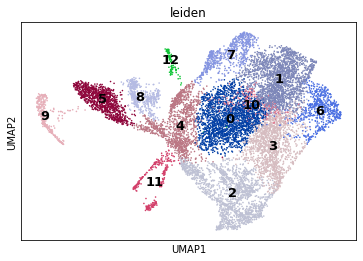

In [215]:
sc.pp.pca(adata, n_comps=75)
sc.pp.neighbors(adata, n_neighbors=knn)
sc.tl.leiden(adata, random_state=random_state, 
            resolution=0.5)
sc.tl.umap(adata, random_state=random_state)

sc.pl.umap(adata, color='leiden', 
           legend_loc='on data', 
           legend_fontsize=13)

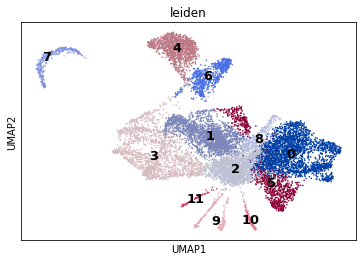

In [216]:
adata.var['highly_variable'] = [g in best_genes_list 
                               for g in adata.var_names]

sc.pp.pca(adata, n_comps=75)
sc.pp.neighbors(adata, n_neighbors=knn)
sc.tl.leiden(adata, random_state=random_state,
            resolution=0.5)
sc.tl.umap(adata, random_state=random_state)

sc.pl.umap(adata, color='leiden', 
           legend_loc='on data', 
           legend_fontsize=13)

## TODO: Compare methods

# Detect cells with higher contribution from HVGs

When calculating the KNN counts for each gene, we can apply this information to find which cells contribute more to the cell identities which separate the clusters.

In order to do that the main strategy is to assign each cell a score, based on the knn counts for each gene. We will study different transformations to adapt the score.

So far, we will assume different options:
* Each gene is independent
* The score for each gene might be either the same or proportional to the Wasserstein distance.
* The score for each cell within each gene can be the same for each cell, the original knn counts, or a scaling.

In [220]:
adata.X = adata.layers['raw_counts']

In [221]:
expression_counts_adata_norm_knn_norm_with_zeros, categories = return_expression_info(list_genes[:N], adata, 
                                                                           knn_indices_adata_norm_knn_norm, 
                                                           category_name = 0, fill_zeros=True)

dict_wassers = {df_bokeh['n'].loc[i]: df_bokeh['e_correct'].loc[i] for i in range(len(df_bokeh))} 

2020-04-08 14:04:06,766	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-04-08 14:04:06,771	INFO resource_spec.py:212 -- Starting Ray with 202.49 GiB memory available for workers and up to 18.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-08 14:04:20,354	INFO services.py:1078 -- View the Ray dashboard at localhost:8265


In [277]:
def get_knn_score(dict_expression_per_gene, scores_per_gene, gene_list = None, scale_knn_per_gene=True, 
                  apply_score=True, scale_all_scores=False, log=True):
    if gene_list is not None:
        dict_expression_per_gene = {k: dict_expression_per_gene[k] for k in gene_list 
                                    if k in dict_expression_per_gene}
        scores_per_gene = {k: scores_per_gene[k] for k in gene_list if k in scores_per_gene}
        
    array_knn_expression = np.array(list(dict_expression_per_gene.values())).transpose()
    
    if scale_knn_per_gene:
        array_knn_expression /= np.max(array_knn_expression, axis=0)
        
    if apply_score:
        array_knn_expression *= np.array(list(scores_per_gene.values()))
    
    scores_per_cell = array_knn_expression.sum(1)
    
    if scale_all_scores:
        scores_per_cell /= array_knn_expression.shape[1]
    
    if log:
        scores_per_cell = np.log10(scores_per_cell)
    
    return scores_per_cell

In [314]:
adata.obs['score_per_cell'] = get_knn_score(expression_counts_adata_norm_knn_norm_with_zeros, dict_wassers, 
                                           scale_all_scores=False, log=True, gene_list = best_genes_list)

In [254]:
adata.var['highly_variable'] = [g in best_genes_list 
                               for g in adata.var_names]

sc.pp.pca(adata, n_comps=75)
sc.pp.neighbors(adata, n_neighbors=knn)
sc.tl.leiden(adata, random_state=random_state, resolution=0.8)
sc.tl.umap(adata, random_state=random_state)

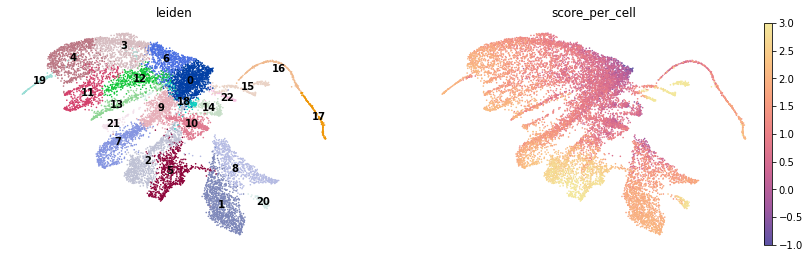

In [328]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

sunset = ['#f3e79b','#fac484','#f8a07e','#eb7f86','#ce6693', '#a059a0','#5c53a5']
sunsetdark = ['#fcde9c','#faa476','#f0746e','#e34f6f','#dc3977','#b9257a','#7c1d6f']
cmap = LinearSegmentedColormap.from_list('custom cmap', sunset[::-1], N=256)
cmap.set_bad('#efefef')


sc.pl.umap(adata, color=['leiden', 'score_per_cell'], legend_loc='on data', frameon=False, 
           cmap=cmap, plotnonfinite=True, 
           vmin = -1, vmax = 3)

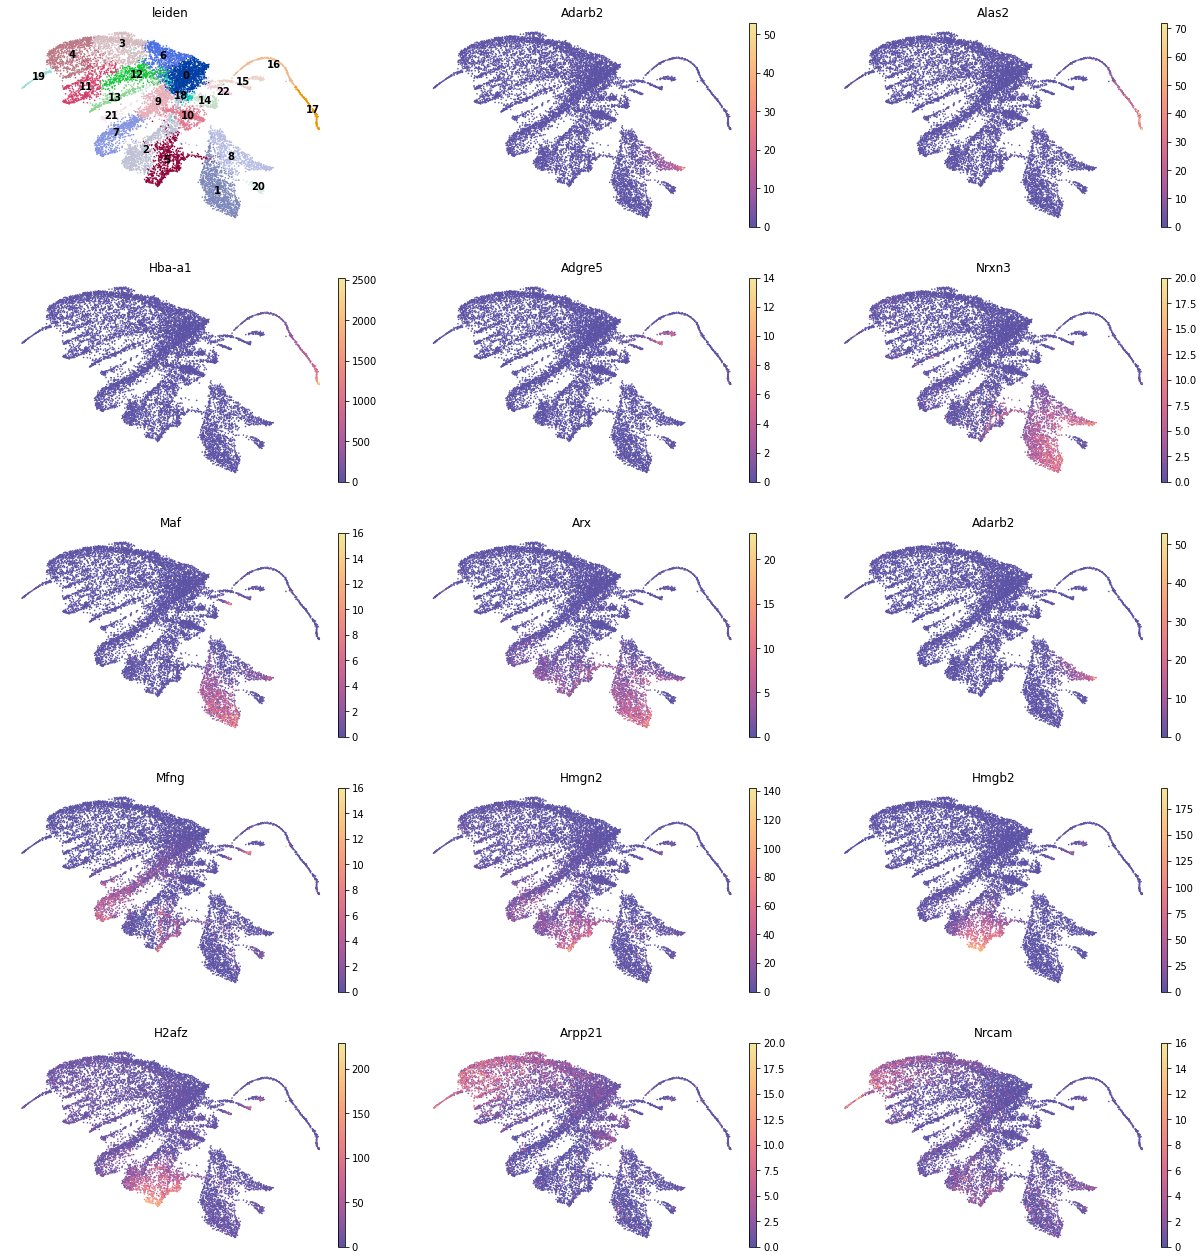

True 2.7090560286988206 4.652517918259724


In [337]:
sc.pl.umap(adata, color=['leiden', 'Adarb2', 'Alas2', 'Hba-a1', 'Adgre5', 'Nrxn3', 'Maf',
                        'Arx', 'Adarb2', 'Mfng', 'Hmgn2', 'Hmgb2', 'H2afz', 'Arpp21', 'Nrcam'], legend_loc='on data', frameon=False, 
           cmap=cmap, plotnonfinite=True, use_raw=False, ncols=3)
print('Adarb2' in best_genes_list, y_cutoff, dict_wassers['Adarb2'])

In [233]:
sc.tl.rank_genes_groups(adata, groupby='leiden')

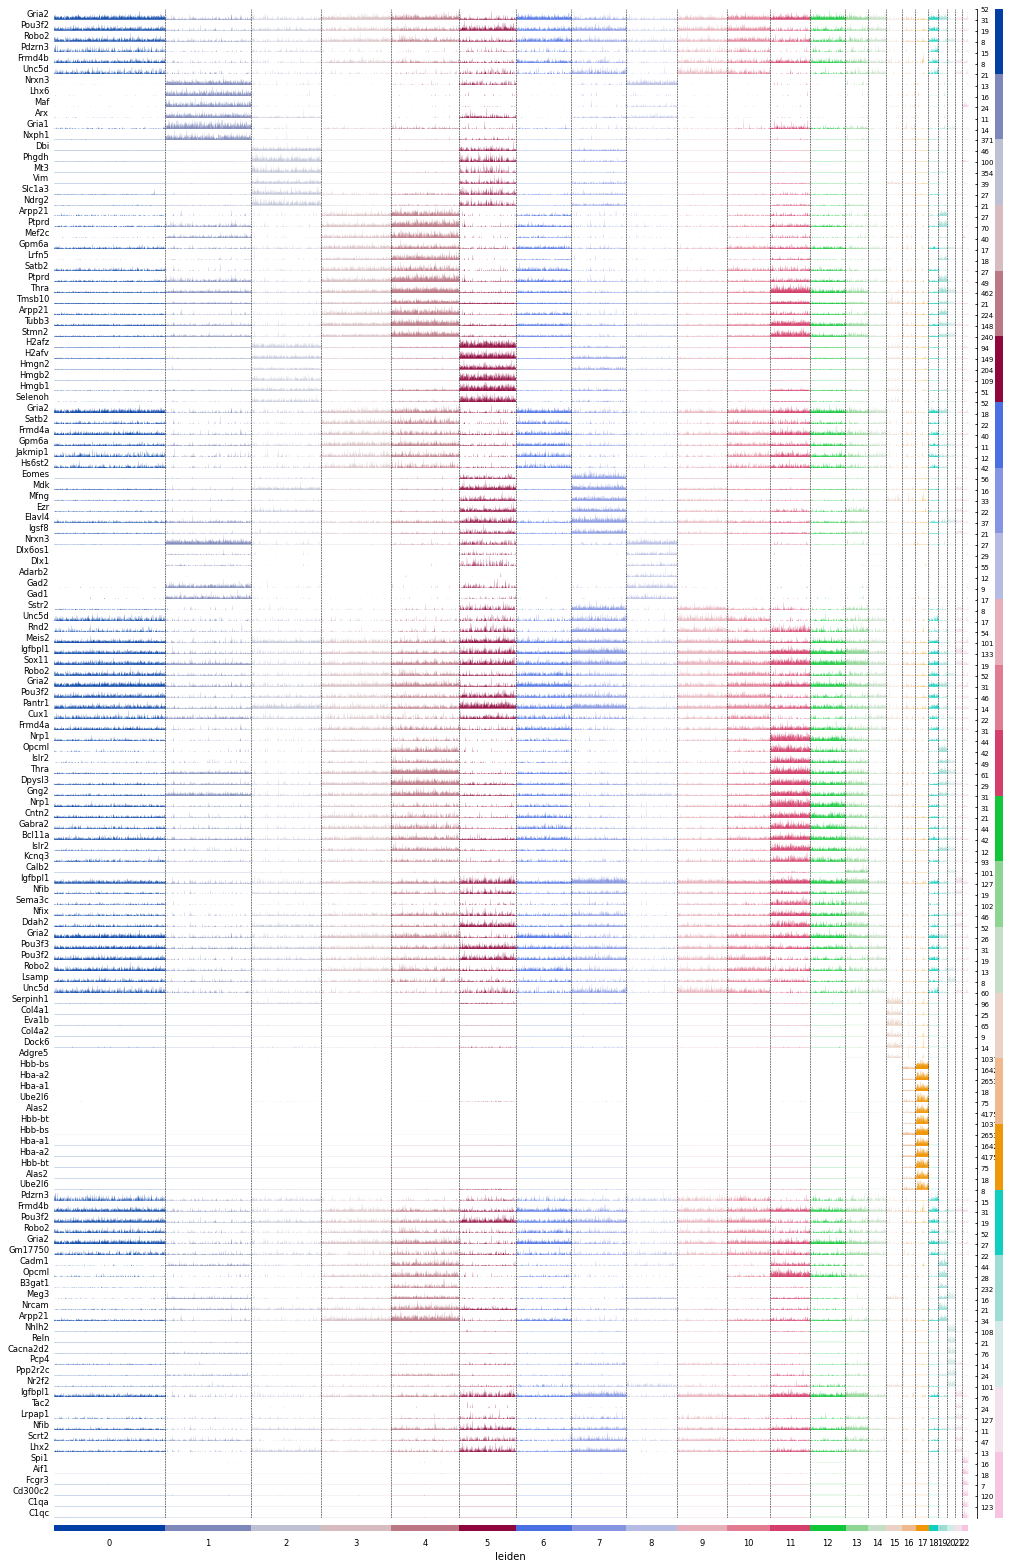

In [243]:
sc.pl.rank_genes_groups_tracksplot(adata, dendrogram=False, n_genes=6, figsize=(17, 28))